In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as Layers
import tensorflow_hub as hub
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files = [
    os.path.join(
      os.path.join(os.getcwd(), 'drive/MyDrive/sports/train/baseball'),
      f
    )
    for f in os.listdir(os.path.join(os.getcwd(), 'drive/MyDrive/sports/train/baseball'))
]

In [ ]:
print(len(tf.config.list_physical_devices('GPU')))

1


In [ ]:
generator = ImageDataGenerator(rescale=1./255, dtype='float32')

train = generator.flow_from_directory(
    '/content/drive/MyDrive/sports/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
  ], name='augmentation'
)

val = generator.flow_from_directory(
    '/content/drive/MyDrive/sports/valid',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
sample_im, sample_label = train.next()
sample_im[0].shape

(224, 224, 3)

In [ ]:
sample_label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
len(train)

422

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 5, verbose=1, mode='auto', restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    augmentation,
    hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2", trainable=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(train.class_indices), activation=tf.keras.activations.softmax)
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["Accuracy"])

with tf.device(tf.test.gpu_device_name()):
  model.fit(train,validation_data=val,epochs=5,callbacks=[earlystop,lr], steps_per_epoch=len(train), validation_steps=int(len(val)*0.1))

Epoch 1/5
422/422 [==============================] - 3344s 8s/step - loss: 2.0130 - Accuracy: 0.5935 - val_loss: 0.3499 - val_Accuracy: 0.8958 - lr: 0.0100
Epoch 2/5
422/422 [==============================] - 49s 116ms/step - loss: 0.9055 - Accuracy: 0.7481 - val_loss: 0.3057 - val_Accuracy: 0.8750 - lr: 0.0100
Epoch 3/5
422/422 [==============================] - 50s 118ms/step - loss: 0.8303 - Accuracy: 0.7702 - val_loss: 0.3849 - val_Accuracy: 0.8750 - lr: 0.0100
Epoch 4/5
422/422 [==============================] - 51s 121ms/step - loss: 0.8029 - Accuracy: 0.7738 - val_loss: 0.2662 - val_Accuracy: 0.9167 - lr: 0.0100
Epoch 5/5
422/422 [==============================] - 51s 121ms/step - loss: 0.7604 - Accuracy: 0.7868 - val_loss: 0.2660 - val_Accuracy: 0.8958 - lr: 0.0100


In [ ]:
model.save('/content/drive/MyDrive/sportsEN_V2.h5')

NameError: name 'model' is not defined

In [ ]:
modeljson = model.to_json()
with open('/content/drive/MyDrive/sportsEN_V2.json','w') as f:
  f.write(modeljson)

from keras.models import save_model
model_saved = save_model(model,'/content/drive/MyDrive/sportsEN_V2.hdf5')

<ipython-input-6-9545ce83cefd>:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model,'/content/drive/MyDrive/sportsEN_V2.hdf5')


In [ ]:
model_ex = tf.keras.models.load_model('/content/drive/MyDrive/sportsEN_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 5, verbose=1, mode='auto', restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto')

with tf.device(tf.test.gpu_device_name()):
  model_ex.fit(train,validation_data=val,epochs=10,callbacks=[earlystop,lr], steps_per_epoch=len(train), validation_steps=int(len(val)*0.1))

Epoch 1/10
422/422 [==============================] - 4660s 11s/step - loss: 0.7539 - Accuracy: 0.7904 - val_loss: 0.3568 - val_Accuracy: 0.9167 - lr: 0.0100
Epoch 2/10
422/422 [==============================] - 62s 147ms/step - loss: 0.7493 - Accuracy: 0.7910 - val_loss: 0.4530 - val_Accuracy: 0.8542 - lr: 0.0100
Epoch 3/10
422/422 [==============================] - 63s 149ms/step - loss: 0.7348 - Accuracy: 0.7997 - val_loss: 0.1947 - val_Accuracy: 0.9583 - lr: 0.0100
Epoch 4/10
422/422 [==============================] - 64s 152ms/step - loss: 0.7424 - Accuracy: 0.7988 - val_loss: 0.2675 - val_Accuracy: 0.9167 - lr: 0.0100
Epoch 5/10
422/422 [==============================] - ETA: 0s - loss: 0.7236 - Accuracy: 0.8059
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
422/422 [==============================] - 66s 157ms/step - loss: 0.7236 - Accuracy: 0.8059 - val_loss: 0.3519 - val_Accuracy: 0.8750 - lr: 0.0100
Epoch 6/10
422/422 [=============================

In [ ]:
model_ex.save('/content/drive/MyDrive/sportsEN_V2_0219.h5')

modeljson = model_ex.to_json()
with open('/content/drive/MyDrive/sportsEN_V2_0219.json','w') as f:
  f.write(modeljson)

from keras.models import save_model
model_saved = save_model(model_ex,'/content/drive/MyDrive/sportsEN_V2_0219.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-8-2d70562b0027>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model_ex,'/content/drive/MyDrive/sportsEN_V2_0219.hdf5')


In [ ]:
with tf.device(tf.test.gpu_device_name()):
  model_ex.fit(train,validation_data=val,epochs=20,callbacks=[earlystop,lr], steps_per_epoch=len(train), validation_steps=int(len(val)*0.1))

Epoch 1/20
422/422 [==============================] - 64s 152ms/step - loss: 0.2608 - Accuracy: 0.9205 - val_loss: 0.1351 - val_Accuracy: 0.9375 - lr: 4.0000e-04
Epoch 2/20
422/422 [==============================] - 63s 150ms/step - loss: 0.2633 - Accuracy: 0.9202 - val_loss: 0.1309 - val_Accuracy: 0.9375 - lr: 4.0000e-04
Epoch 3/20
422/422 [==============================] - 61s 145ms/step - loss: 0.2495 - Accuracy: 0.9238 - val_loss: 0.1167 - val_Accuracy: 0.9583 - lr: 4.0000e-04
Epoch 4/20
422/422 [==============================] - 65s 154ms/step - loss: 0.2503 - Accuracy: 0.9248 - val_loss: 0.1457 - val_Accuracy: 0.9167 - lr: 4.0000e-04
Epoch 5/20
422/422 [==============================] - ETA: 0s - loss: 0.2446 - Accuracy: 0.9229
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
422/422 [==============================] - 62s 146ms/step - loss: 0.2446 - Accuracy: 0.9229 - val_loss: 0.1433 - val_Accuracy: 0.9375 - lr: 4.0000e-04
Epoch 6/20
422/422 [=========

In [ ]:
model_ex.save('/content/drive/MyDrive/sportsEN_V2_0219_2.h5')

modeljson = model_ex.to_json()
with open('/content/drive/MyDrive/sportsEN_V2_0219_2.json','w') as f:
  f.write(modeljson)

from keras.models import save_model
model_saved = save_model(model_ex,'/content/drive/MyDrive/sportsEN_V2_0219_2.hdf5')

<ipython-input-12-b348f2b4fda8>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model_ex,'/content/drive/MyDrive/sportsEN_V2_0219_2.hdf5')


In [ ]:
generator = ImageDataGenerator(rescale=1./255, dtype='float32')
test = generator.flow_from_directory(
    '/content/drive/MyDrive/sports/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 500 images belonging to 100 classes.


In [ ]:
# get label
import pandas as pd
class_df = pd.read_csv('/content/drive/MyDrive/sports/sports.csv')
class_df = class_df[['class id','labels']]
class_df.columns = ['id','labels']
class_label = {str(row.id): row.labels for row in class_df.itertuples()}

In [ ]:
model_ex = tf.keras.models.load_model('/content/drive/MyDrive/sportsEN_V2_0219_2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
model_ex.evaluate(test)

500/500 [==============================] - 38s 74ms/step - loss: 0.2743 - Accuracy: 0.9180


[0.27427488565444946, 0.9179999828338623]

In [ ]:
for lay in model_ex.layers:
  print(f"{lay.name} --> {lay.trainable}")

augmentation --> True
keras_layer --> False
batch_normalization --> True
dense --> True


In [ ]:
def reshape_image(img, size=224):
  return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def read_file(path, forPloting = False):
  if not forPloting:
    im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    im = reshape_image(im)
    im = tf.expand_dims(im, axis = 0)
    return np.float32(im/255)
  else:
    im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return reshape_image(im, 1000)

def show_image(img=None, path=None):
  if img is None:
    if path is None:
      return None
    img = read_file(path)
  plt.imshow(img)
  plt.axis(False)
  plt.show()

In [ ]:
def predict_im(img=None, path=None, val_label=None, class_label=class_label):
  if img is None:
    if path is None:
      return None
    img = read_file(path)
  imx = img.copy()

  if imx.ndim == 3:
    imx = tf.expand_dims(imx, axis = 0)
  elif imx.ndim == 4:
    pass
  else:
    print("image shape needs to have a dimension of 3 or 4")
    raise

  with tf.device(tf.test.gpu_device_name()):
    pred = model_ex.predict(imx)
  print(f"Prediction: {[class_label[str(pred[i].argmax())] for i in range(len(pred))]}")
  if val_label is not None:
    print(f"Real label: {[class_label[str(val_label[i].argmax())] for i in range(len(val_label))]}")

In [ ]:
im, label = test.next()
predict_im(img=im,val_label=label,class_label=class_label)

1/1 [==============================] - 0s 117ms/step
Prediction: ['air hockey']
Real label: ['air hockey']


In [ ]:
show_image(path='/content/temp.png')
predict_im(path='/content/temp.png', class_label=class_label)

In [ ]:
path = '/content/temp.png'
img = read_file(path)
img = tf.expand_dims(img, axis = 0)

In [ ]:
prob = model_ex.predict(img)
print(prob.shape)
print(prob[0].sum())
print(prob[0].max())

1/1 [==============================] - 0s 82ms/step
(1, 100)
1.0
0.97367555


In [ ]:
def result_with_prob(img=None, path=None, n=5):
  if img is None:
    if path is None:
      return None
    img = read_file(path)

  if img.ndim == 3:
    img = tf.expand_dims(img, axis = 0)
  elif img.ndim == 4:
    pass

  prob = model_ex.predict(img)
  dtype = [('class_index', int), ('prob', float)]
  value = [(int(i), prob[0][i]) for i in range(len(prob[0]))]

  results = np.array(value, dtype=dtype)
  results = np.sort(results, order='prob')[::-1]

  return {class_label[str(result[0])]: result[1] for result in results[:n]}

In [ ]:
d = result_with_prob(img=img, n=10)

1/1 [==============================] - 0s 121ms/step


In [ ]:
d.keys()

dict_keys(['nascar racing', 'formula 1 racing', 'air hockey', 'motorcycle racing', 'sidecar racing', 'ski jumping', 'bobsled', 'hurdles', 'hockey', 'shuffleboard'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def predict_img(path=None, n=5):
  img = read_file(path)
  img_plot = read_file(path, True)

  results = result_with_prob(img=img, path=None, n=n)

  fig = plt.figure(figsize = (9,4))
  ax = fig.add_axes([0,0,1,1])
  ax_sub = fig.add_axes([0.4,0.15,0.8,0.8])
  ax.bar(results.keys(), results.values(), color='#2F4F4F')
  ax.set_title('Image Prediction Probability', fontdict = {'fontsize':20})
  ax_sub.imshow(img_plot)
  ax_sub.axis('off')
  ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

  ax.grid(color='#DCDCDC', alpha=0.3, linestyle='dashed', linewidth=0.1)
  for label in ax.get_xticklabels():
      label.set_rotation(20)
  plt.show()

  return results

1/1 [==============================] - 1s 557ms/step


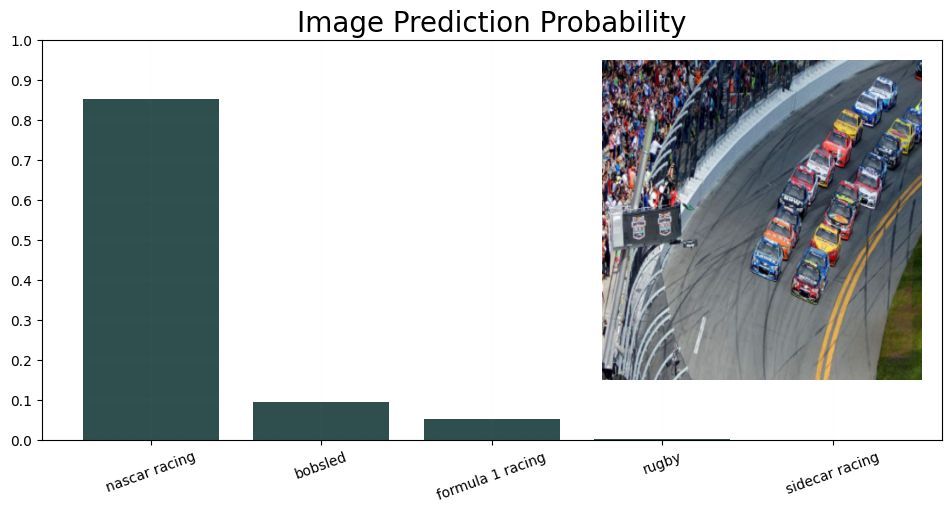

In [ ]:
r = predict_img(path='/content/temp.png', n=5)

In [ ]:
from PIL import Image
def read_pillowimage(path):
  loaded_image = Image.open(path)
  pillow1 = np.array(loaded_image.resize((224,224)))
  pillow1 = np.float32(pillow1/255)
  pillow1 = pillow1[:, :, :3]
  return pillow1

In [ ]:
im = read_pillowimage('/content/temp.png')
predict_im(img=im)

1/1 [==============================] - 0s 48ms/step
Prediction: ['nascar racing']


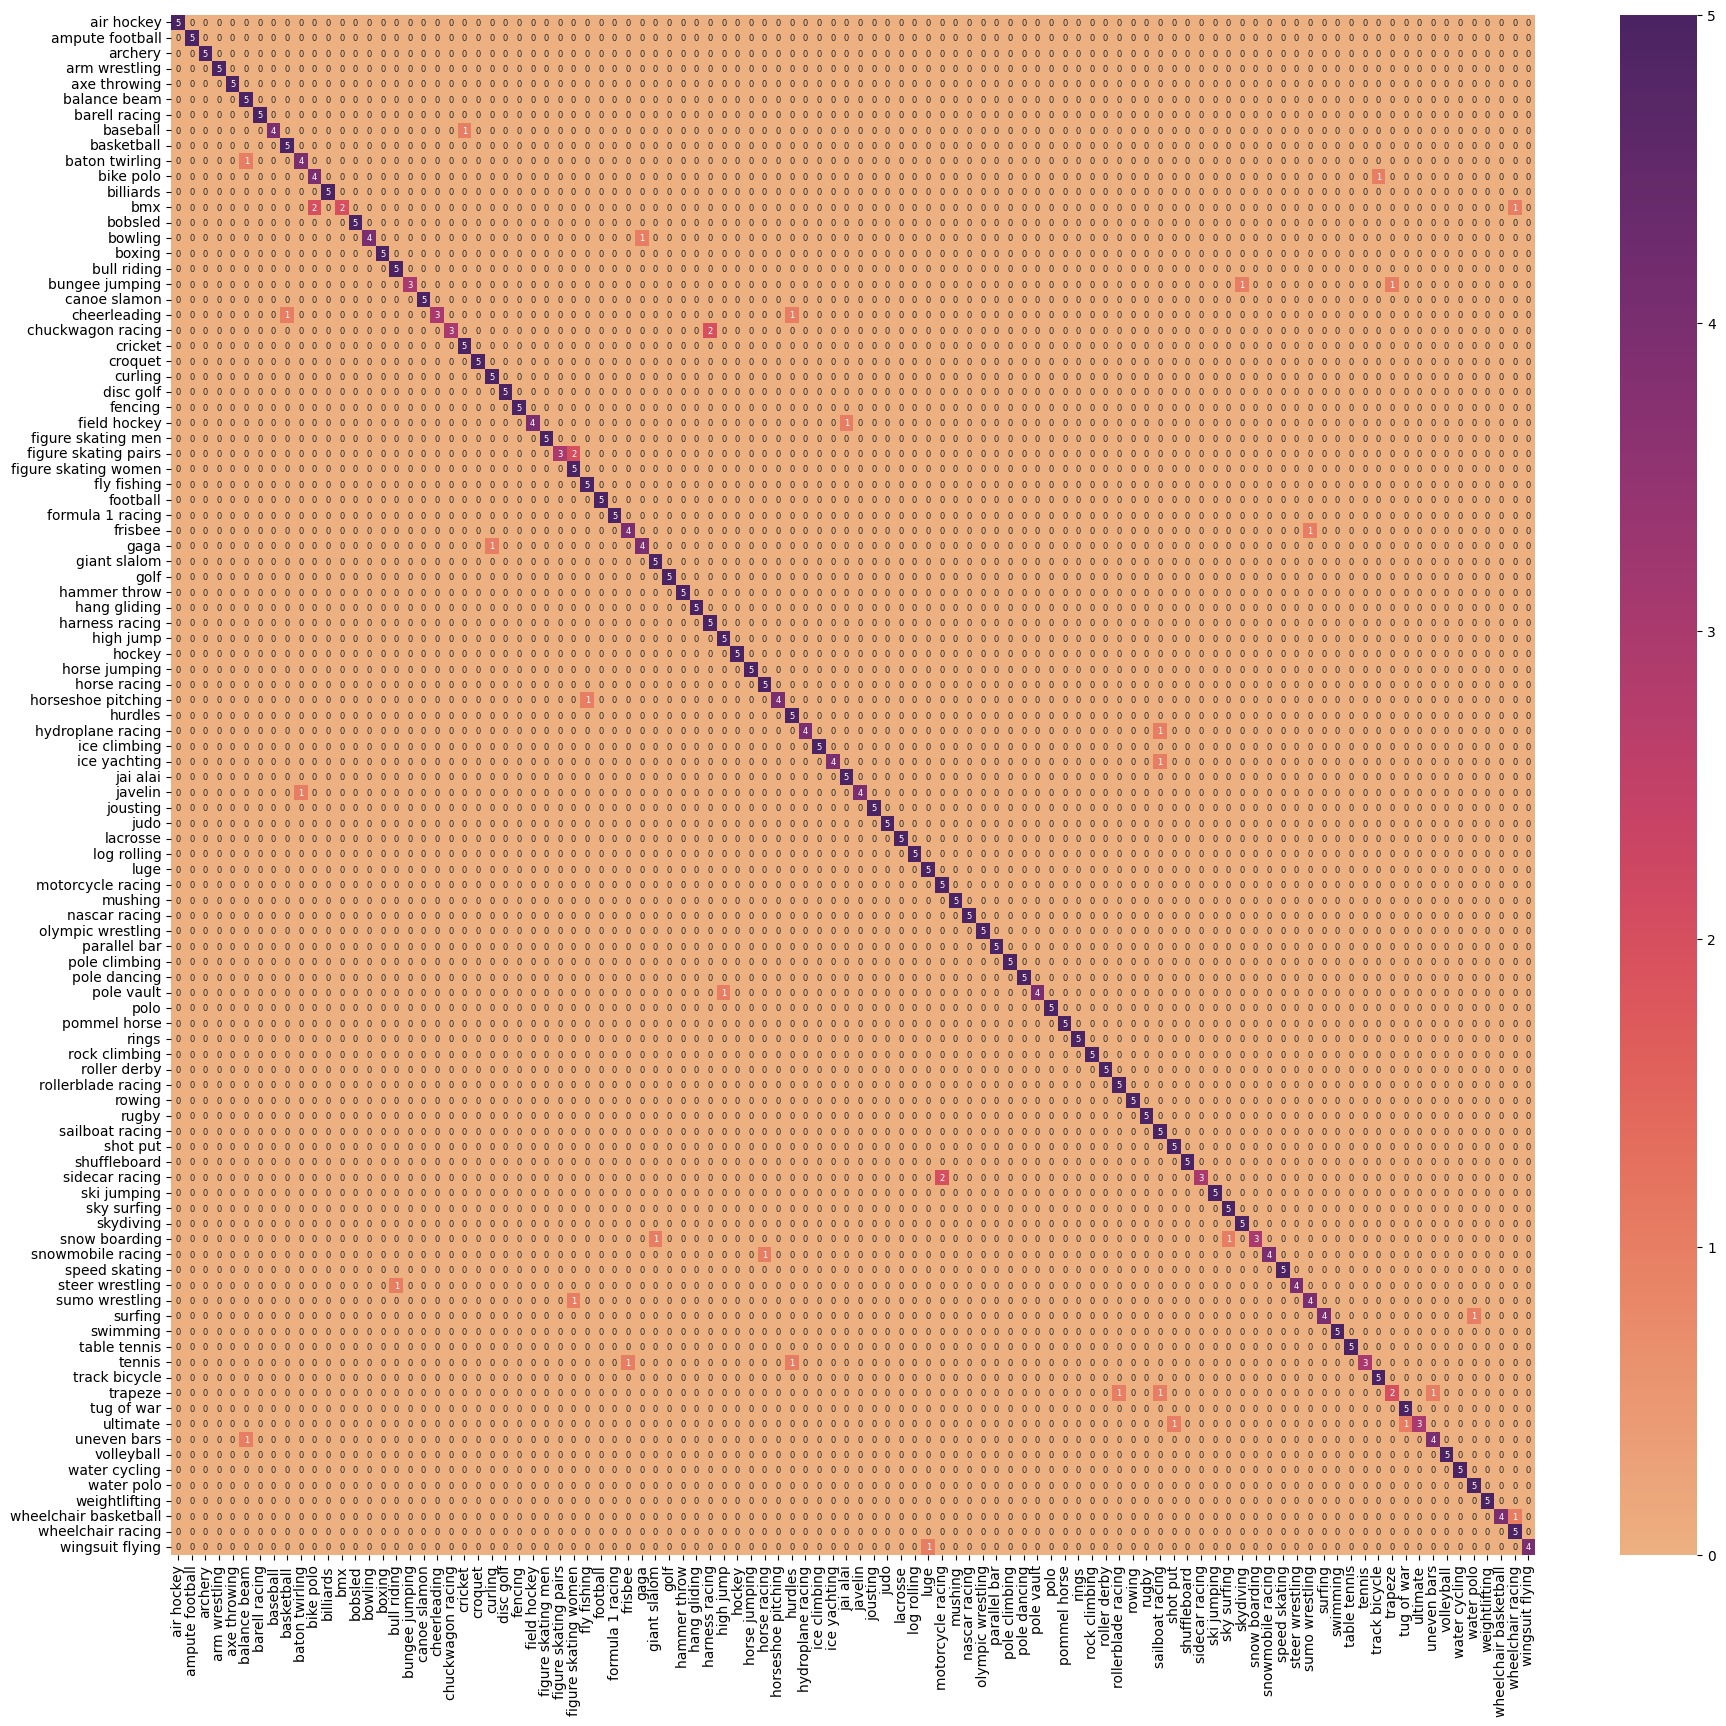

In [ ]:
pred_list = []; real_list = []; i = 0
for data, label in test:
  prob = model_ex.predict(data, verbose=0)
  pred = int(prob[0].argmax())
  real = int(label[0].argmax())
  pred_list.append(pred)
  real_list.append(real)
  i =+ 1
    if i == 500:
      break

M = confusion_matrix(y_true=real_list, y_pred=pred_list)
plt.figure(figsize = (22,20))
sns.heatmap(M,annot = True, cmap = 'flare',fmt = 'd',
            xticklabels=list(class_label.values()), yticklabels = list(class_label.values()),
            annot_kws={"fontsize":6})
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def prediction_info(batch=test, class_label=class_label):
  pred_list = []; real_list = []; i = 0
  for data, label in test:
    prob = model_ex.predict(data, verbose=0)
    pred = class_label[str(prob[0].argmax())]
    real = class_label[str(label[0].argmax())]
    pred_list.append(pred)
    real_list.append(real)
    i =+ 1
    if i == 500:
      break

  M = confusion_matrix(y_true=real_list, y_pred=pred_list)
  plt.figure(figsize = (22,20))
  sns.heatmap(M,annot = True, cmap = 'flare',fmt = 'd',
              #xticklabels=train10.class_names, yticklabels = train10.class_names,
              annot_kws={"fontsize":6})
  plt.show()

In [ ]:
url = "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/classification/versions/1"
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 5, verbose=1, mode='auto', restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    augmentation,
    hub.KerasLayer(url, trainable=False, input_shape=(224,224,3)),
    tf.keras.layers.Dense(1000, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train.class_indices), activation=tf.keras.activations.softmax)
])

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["Accuracy"])

with tf.device(tf.test.gpu_device_name()):
  model.fit(train,validation_data=val,epochs=10,callbacks=[earlystop,lr], steps_per_epoch=len(train), validation_steps=int(len(val)*0.1))

Epoch 1/10
422/422 [==============================] - 84s 177ms/step - loss: 2.3808 - Accuracy: 0.3806 - val_loss: 1.9508 - val_Accuracy: 0.5625 - lr: 0.0100
Epoch 2/10
422/422 [==============================] - 64s 152ms/step - loss: 1.9186 - Accuracy: 0.4804 - val_loss: 1.8154 - val_Accuracy: 0.5833 - lr: 0.0100
Epoch 3/10
422/422 [==============================] - 66s 155ms/step - loss: 1.8080 - Accuracy: 0.5052 - val_loss: 1.5907 - val_Accuracy: 0.6458 - lr: 0.0100
Epoch 4/10
422/422 [==============================] - 65s 153ms/step - loss: 1.7368 - Accuracy: 0.5289 - val_loss: 1.9703 - val_Accuracy: 0.6667 - lr: 0.0100
Epoch 5/10
422/422 [==============================] - 64s 152ms/step - loss: 1.6582 - Accuracy: 0.5459 - val_loss: 1.2954 - val_Accuracy: 0.7292 - lr: 0.0100
Epoch 6/10
422/422 [==============================] - 64s 151ms/step - loss: 1.6156 - Accuracy: 0.5557 - val_loss: 1.4720 - val_Accuracy: 0.7500 - lr: 0.0100
Epoch 7/10
422/422 [==============================] 

In [ ]:
model.fit(train,validation_data=val,epochs=10,callbacks=[earlystop,lr], steps_per_epoch=len(train), validation_steps=int(len(val)*0.1))

Epoch 1/10
422/422 [==============================] - 72s 170ms/step - loss: 1.2125 - Accuracy: 0.6469 - val_loss: 0.8904 - val_Accuracy: 0.8750 - lr: 0.0020
Epoch 2/10
422/422 [==============================] - 67s 158ms/step - loss: 1.1812 - Accuracy: 0.6535 - val_loss: 0.9799 - val_Accuracy: 0.8542 - lr: 0.0020
Epoch 3/10
422/422 [==============================] - ETA: 0s - loss: 1.1509 - Accuracy: 0.6582
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
422/422 [==============================] - 63s 150ms/step - loss: 1.1509 - Accuracy: 0.6582 - val_loss: 0.9369 - val_Accuracy: 0.8333 - lr: 0.0020
Epoch 4/10
422/422 [==============================] - 66s 156ms/step - loss: 1.1127 - Accuracy: 0.6680 - val_loss: 0.9432 - val_Accuracy: 0.8125 - lr: 4.0000e-04
Epoch 5/10
422/422 [==============================] - ETA: 0s - loss: 1.1064 - Accuracy: 0.6728
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.
422/422 [======================

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = r"'/content/drive/MyDrive/sports/train'"
print(train_dir)

'/content/drive/MyDrive/sports/train'


In [ ]:
train_transforms = v2.Compose([
    v2.Resize(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(degrees=(0,15)),
    v2.ToTensor(),
    v2.Normalize(
        [0.485, 0.456, 0.406],
        [0.229,0.224,0.225]
    )
])

train_df = datasets.ImageFolder(
    root = r'/content/drive/MyDrive/sports/train',
    transform= train_transforms,
    )


val_transforms = v2.Compose([
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(
        [0.485, 0.456, 0.406],
        [0.229,0.224,0.225]
    )
])

val_df = datasets.ImageFolder(
    root = r'/content/drive/MyDrive/sports/valid',
    transform= val_transforms,
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
im, label = next(iter(train_df))
print(im.shape)

torch.Size([3, 224, 224])


In [ ]:
label

0

In [ ]:
train_loader = torch.utils.data.DataLoader(train_df, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_df, batch_size=100, shuffle=False)

In [ ]:
for (X, label) in train_loader:
  print(X.shape, label)
  break

torch.Size([32, 3, 224, 224]) tensor([71, 85, 30, 26, 37, 28, 67, 16, 40, 80, 41, 68, 56, 23, 92, 73, 35, 29,
        40, 64, 86, 95, 87, 41, 58, 47, 37, 69, 52, 20, 13, 66])


In [ ]:
class CNNet(nn.Module):
  def __init__(self):
    super(CNNet, self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2),
      nn.Dropout(p=0.2)
    ) #224 -> 112
    self.conv2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2),
      nn.Dropout(p=0.2)
    ) #112 -> 56
    self.conv3 = nn.Sequential(
      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2),
      nn.Dropout(p=0.2)
    ) #56 -> 28
    self.func1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*28*28, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.2)
    )
    self.func2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.2)
    )
    self.func3 = nn.Linear(256, 100)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.func1(x)
    x = self.func2(x)
    x = self.func3(x)
    out = nn.functional.log_softmax(x, dim=1)
    return out

In [ ]:
device = torch.device('cuda')
model = CNNet().to(device)
loss_function = nn.NLLLoss() #for logsoftmax
optimizer = optim.Adam(model.parameters(), lr = 0.001)

def train(
    model, device=None, train_loader=train_loader, val_loader=val_loader,
    loss_function=loss_function, optimizer=optimizer, epochs=10
  ):
  train_loss = []
  train_accuracy = []
  val_loss = []
  val_accuracy = []

  for e in range(epochs):
    model.train()
    total = 0
    losses = 0.0
    corrects = 0
    train_running_loss = 0
    for i, (X,y) in enumerate(train_loader):
      if device:
        X,y = X.to(device), y.to(device)
      optimizer.zero_grad()
      output = model(X)
      loss = loss_function(output, y)
      loss.backward()
      optimizer.step()
      _, pred = torch.max(output.data, 1)

      losses += loss.item()/X.size(0)
      corrects += torch.sum(pred == y.data)/X.size(0)
    train_loss.append(losses/len(train_loader))
    train_accuracy.append(corrects/len(train_loader))

    if True:
      model.eval()
      lossest = 0.0
      correctst = 0
      for Xt, yt in val_loader:
        with torch.no_grad():
          if device:
            Xt,yt = Xt.to(device), yt.to(device)
          outputt = model(Xt)
          losst = loss_function(outputt, yt)
          _, predt = torch.max(outputt.data, 1)
          lossest += losst.item()/Xt.size(0)
          correctst += torch.sum(predt == yt.data)/Xt.size(0)
      val_loss.append(lossest/len(val_loader))
      val_accuracy.append(correctst.double()/len(val_loader))
      print(f"epochs: {e}, Train loss: {train_loss[e]:.4f}, Val loss: {val_loss[e]:.4f}")
  return train_accuracy,val_accuracy

In [ ]:
acct

[tensor(0.2740, device='cuda:0', dtype=torch.float64),
 tensor(0.3860, device='cuda:0', dtype=torch.float64),
 tensor(0.4800, device='cuda:0', dtype=torch.float64),
 tensor(0.5160, device='cuda:0', dtype=torch.float64),
 tensor(0.5800, device='cuda:0', dtype=torch.float64),
 tensor(0.5340, device='cuda:0', dtype=torch.float64),
 tensor(0.5760, device='cuda:0', dtype=torch.float64),
 tensor(0.6180, device='cuda:0', dtype=torch.float64),
 tensor(0.6300, device='cuda:0', dtype=torch.float64),
 tensor(0.6220, device='cuda:0', dtype=torch.float64)]

In [ ]:
acc, acct = train(model, device=device, epochs=10)

epochs: 0, Train loss: 0.0236, Val loss: 0.0142
epochs: 1, Train loss: 0.0174, Val loss: 0.0146
epochs: 2, Train loss: 0.0156, Val loss: 0.0149
epochs: 3, Train loss: 0.0140, Val loss: 0.0154
epochs: 4, Train loss: 0.0124, Val loss: 0.0157
epochs: 5, Train loss: 0.0117, Val loss: 0.0146
epochs: 6, Train loss: 0.0106, Val loss: 0.0153
epochs: 7, Train loss: 0.0115, Val loss: 0.0151
epochs: 8, Train loss: 0.0094, Val loss: 0.0151
epochs: 9, Train loss: 0.0087, Val loss: 0.0159


In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/sportsCNN_0223.pt")

In [ ]:
acc, acct = train(model, device=device, epochs=5)

epochs: 0, Train loss: 0.0082, Val loss: 0.0161
epochs: 1, Train loss: 0.0095, Val loss: 0.0237
epochs: 2, Train loss: 0.0111, Val loss: 0.0157
epochs: 3, Train loss: 0.0077, Val loss: 0.0273
epochs: 4, Train loss: 0.0167, Val loss: 0.0156


In [ ]:
acct

[tensor(0.6500, device='cuda:0', dtype=torch.float64),
 tensor(0.5480, device='cuda:0', dtype=torch.float64),
 tensor(0.6440, device='cuda:0', dtype=torch.float64),
 tensor(0.5280, device='cuda:0', dtype=torch.float64),
 tensor(0.6600, device='cuda:0', dtype=torch.float64)]

In [ ]:
device = torch.device('cuda')
model = CNNet().to(device)
X = X.to(device)
output = model(X)

In [ ]:
loss_function = nn.NLLLoss() #for logsoftmax
label = label.to(device)

In [ ]:
loss = loss_function(output.data, label)